In [2]:
# STEP 1: Import Required Libraries
!pip install pandas plotly dash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")


In [5]:
# STEP 2: Load the Dataset
df = pd.read_csv('Supermart Dataset.csv')
print("Initial Shape:", df.shape)
df.head()


Initial Shape: (9994, 11)


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [6]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

In [8]:
# Convert order date
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.strftime('%b')


In [9]:
# Supermart Grocery Color Palette
supermart_colors = ["#2E8B57", "#FFA500", "#FFD700", "#8B4513", "#FF6347", "#6B8E23"]


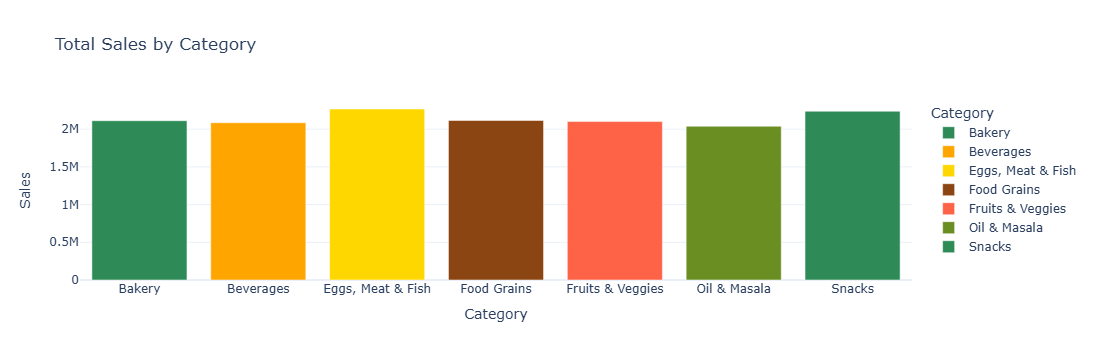

In [10]:
# Plot 1: Sales by Category
sales_category = df.groupby("Category")["Sales"].sum().reset_index()
fig1 = px.bar(
    sales_category, x="Category", y="Sales",
    color="Category",
    color_discrete_sequence=supermart_colors,
    title="Total Sales by Category",
    hover_data={"Sales":":,.0f"}
)
fig1.update_layout(template="plotly_white")


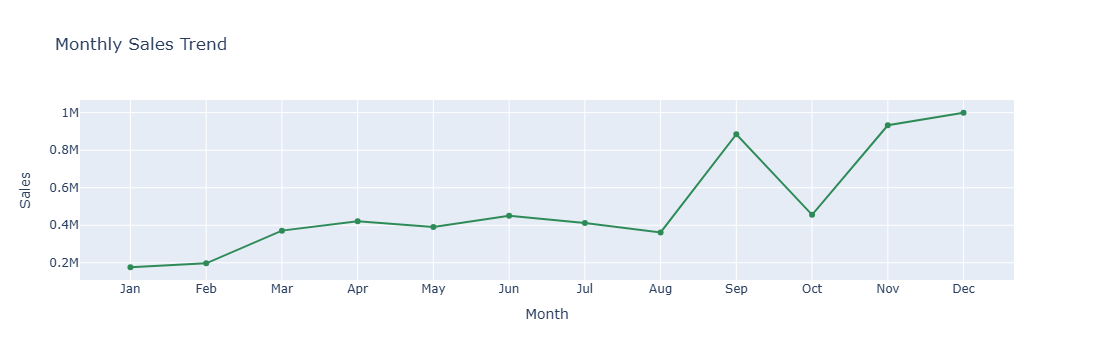

In [12]:
#  FIXED Plot 2: Monthly Sales Trend 

import plotly.express as px

# Ensure datetime & numeric
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df["Sales"] = pd.to_numeric(df["Sales"], errors="coerce")

# Create numeric + label months
df["MonthNo"] = df["Order Date"].dt.month
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

monthly_sales = (
    df.dropna(subset=["MonthNo", "Sales"])
      .groupby("MonthNo", as_index=False)["Sales"].sum()
      .sort_values("MonthNo")
)
monthly_sales["Month"] = monthly_sales["MonthNo"].apply(lambda m: month_labels[int(m)-1])

# Use Supermart palette (fallback if not defined)
palette = [supermart_colors[0]] if "supermart_colors" in globals() else ["#2E8B57"]

# Plot
fig2 = px.line(
    monthly_sales,
    x="Month",
    y="Sales",
    markers=True,
    title="Monthly Sales Trend",
    color_discrete_sequence=palette
)
fig2.update_traces(hovertemplate="Month: %{x}<br>Sales: %{y:,}")
fig2.show()


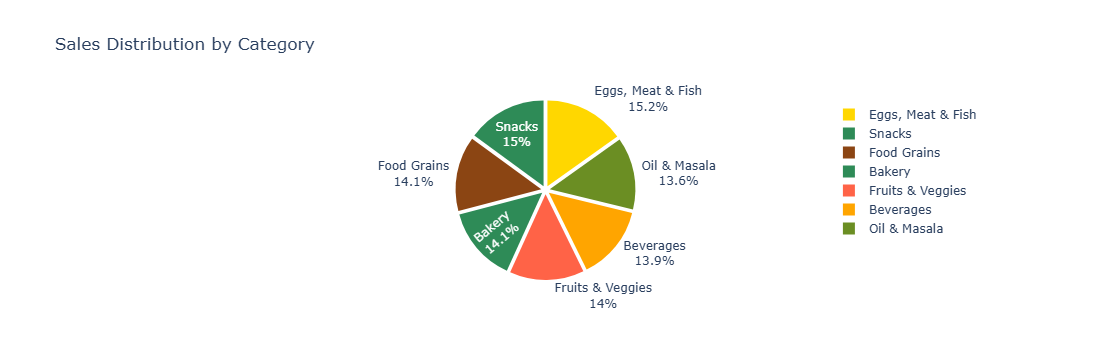

In [13]:
# Plot 3: Sales Distribution by Category (Pie Chart)
sales_category = df.groupby("Category")["Sales"].sum().reset_index()
fig3 = px.pie(
    sales_category,
    values="Sales",
    names="Category",
    title="Sales Distribution by Category",
    color="Category",
    color_discrete_sequence=supermart_colors,
    hover_data=['Sales'] # Changed hover_data to a list containing only the column name
)
fig3.update_traces(
    textinfo="percent+label",
    pull=[0.05] * len(sales_category),
    hovertemplate="<b>%{label}</b><br>Sales: %{value:,.0f}<br>Percentage: %{percent}" # Added hovertemplate for formatting
)
fig3.update_layout(template="plotly_white")
fig3.show()

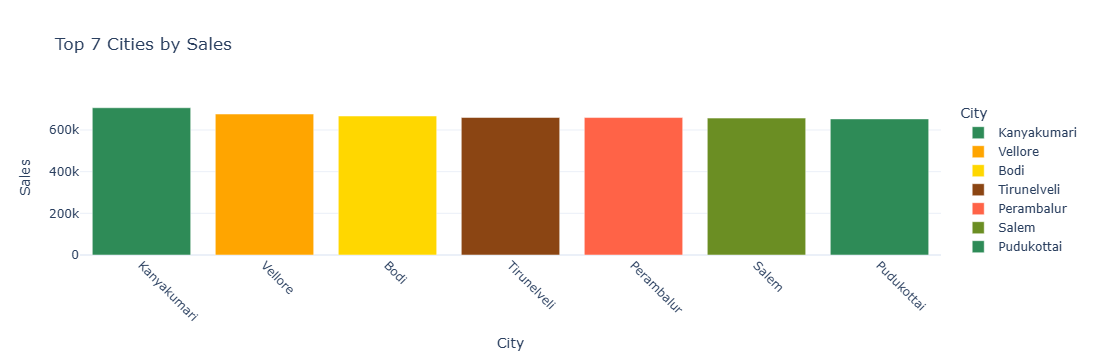

In [14]:
#  Plot 4: Top Cities by Sales
top_cities = df.groupby("City")["Sales"].sum().nlargest(7).reset_index()
fig4 = px.bar(
    top_cities, x="City", y="Sales",
    color="City",
    color_discrete_sequence=supermart_colors,
    title="Top 7 Cities by Sales",
    hover_data={"Sales":":,.0f"}
)
fig4.update_layout(xaxis_tickangle=45, template="plotly_white")


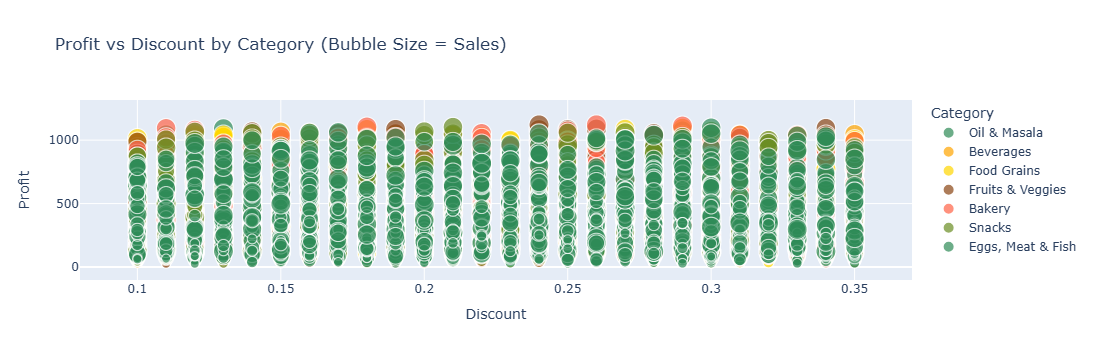

In [15]:
import plotly.express as px

#Plot5: Profit vs Discount Scatter
figA = px.scatter(
    df, x="Discount", y="Profit",
    color="Category",
    size="Sales",
    hover_data=["Sub Category", "City"],
    color_discrete_sequence=supermart_colors,
    title="Profit vs Discount by Category (Bubble Size = Sales)"
)
fig5.update_traces(hovertemplate="Discount: %{x}<br>Profit: %{y}<br>Sales: %{marker.size:,}")
fig5.show()

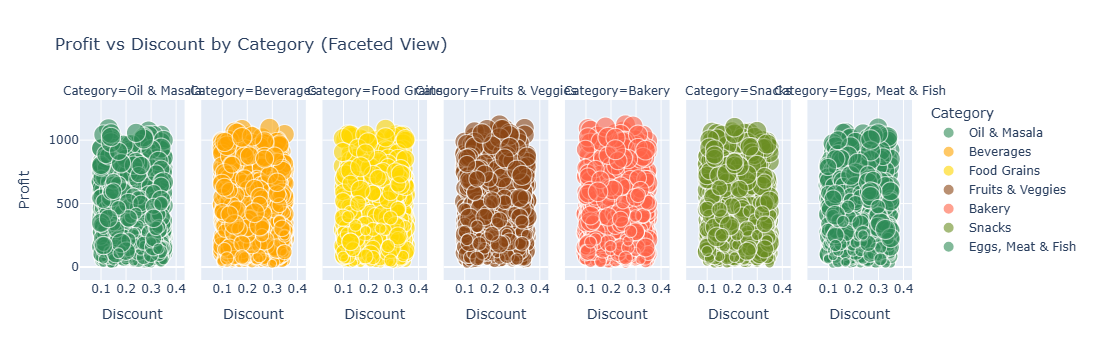

In [16]:
fig6 = px.scatter(
    df, x="Discount", y="Profit",
    size="Sales",
    color="Category",
    hover_data=["Sub Category", "City"],
    opacity=0.6,
    facet_col="Category",  # separate scatter for each category
    color_discrete_sequence=supermart_colors,
    title="Profit vs Discount by Category (Faceted View)"
)

fig6.show()


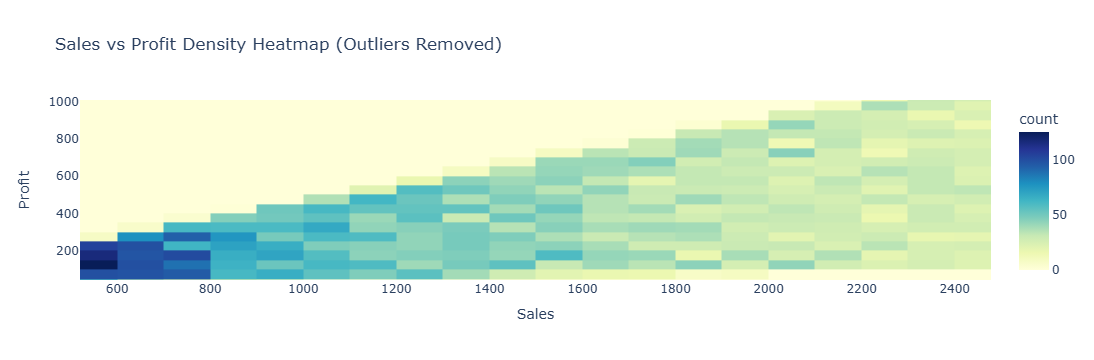

In [17]:
import plotly.express as px

# Limit extreme outliers (focus on middle 95% of data)
sales_min, sales_max = df["Sales"].quantile([0.01, 0.99])
profit_min, profit_max = df["Profit"].quantile([0.01, 0.99])

fig7 = px.density_heatmap(
    df, x="Sales", y="Profit",
    nbinsx=40, nbinsy=40,  # smoother binning
    color_continuous_scale="YlGnBu",
    title="Sales vs Profit Density Heatmap (Outliers Removed)"
)

# Zoom into 1st–99th percentile range (removes extreme values)
fig7.update_layout(
    xaxis=dict(range=[sales_min, sales_max]),
    yaxis=dict(range=[profit_min, profit_max])
)

fig7.update_traces(
    hovertemplate="Sales: %{x}<br>Profit: %{y}<br>Count: %{z}",
    colorbar_title="Density"
)

fig7.show()


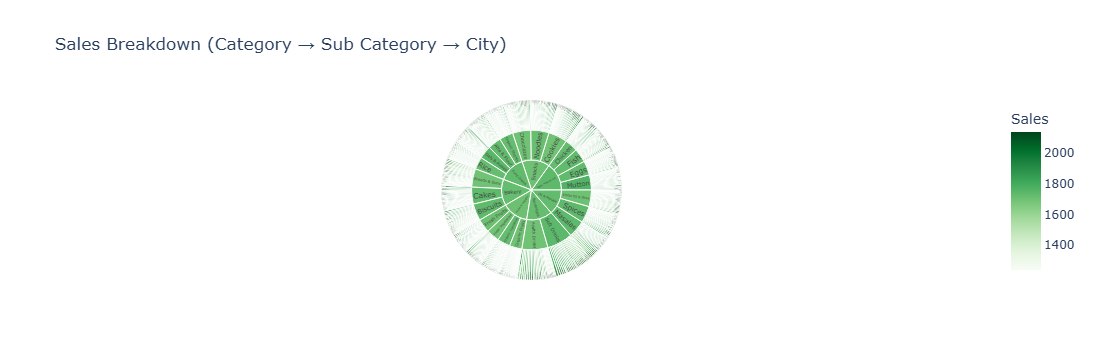

In [18]:
#  Plot8: Sunburst Chart (Category → Sub Category → City)
fig8 = px.sunburst(
    df, path=["Category", "Sub Category", "City"],
    values="Sales",
    color="Sales",
    color_continuous_scale=px.colors.sequential.Greens,
    title="Sales Breakdown (Category → Sub Category → City)"
)
fig8.show()


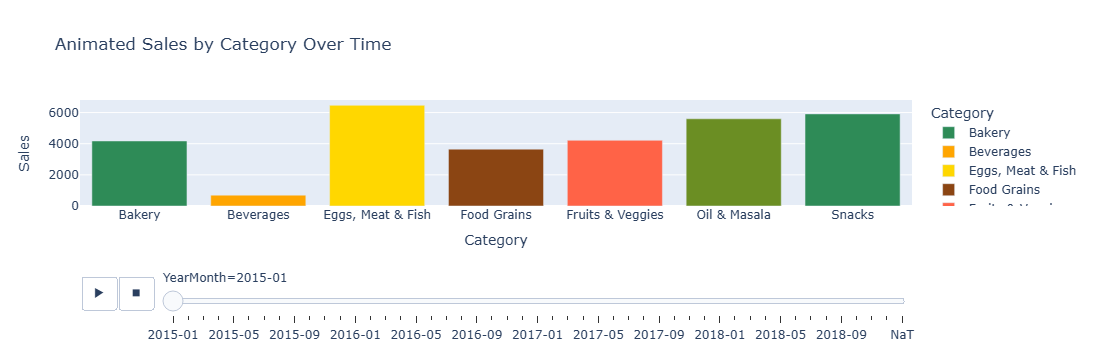

In [19]:
#  Plot 9: Animated Sales Over Time
# Group sales by month-year
df["YearMonth"] = df["Order Date"].dt.to_period("M").astype(str)
time_sales = df.groupby(["YearMonth", "Category"])["Sales"].sum().reset_index()

fig9 = px.bar(
    time_sales, x="Category", y="Sales",
    color="Category",
    animation_frame="YearMonth",
    color_discrete_sequence=supermart_colors,
    title="Animated Sales by Category Over Time"
)
fig9.show()
